# Load Preprocessed data 

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import pandas as pd
import numpy as np
import torch
import random
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# # Load dataset
# data1 = pd.read_csv('dataf_preproc_11_2023.csv')
# data2 = pd.read_csv('dataf_preproc_12_2023.csv')
# data3 = pd.read_csv('dataf_preproc_01_2024.csv')
# dataf = pd.concat([data1, data2, data3])
# # Reset the index (optional)
# dataf = dataf.reset_index(drop=True)
dataf = pd.read_csv('dataf_preproc_12_2023.csv')


In [3]:
unique_reources = dataf["Resource"].value_counts()
print(unique_reources)

# Define features and target variable
X_columns = ['Requested Wall Time', 'Requested Nodes', 'Cores', 'Gpu Count', 'Nodes', 
             'Queue', 'Resource', 'Field of Science', # 'Application', 
             'Active Jobs in Queue', 
             'Active Jobs Running', 'CPU Usage Running', 'Nodes Usage Running' 
            ]

Y_columns = ['Wait Time']

X = dataf[X_columns]
Y = dataf[Y_columns]


# X_all = dataf[X_columns]
# Y_all = dataf[Y_columns]

# data_resource = ['delta-gpu.ncsa.xsede.org'] #['expanse.sdsc.xsede.org']
# resource_mask = X_all["Resource"].isin(data_resource)
# X = X_all[resource_mask]
# Y = Y_all[resource_mask]

# Y = Y / 60

print("Y.shape",Y.shape)
print("X.shape",X.shape)

# Set random seed
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Identify categorical and numerical features
categorical_features = ['Queue', 'Resource', 'Field of Science'] #, 'Application']
numerical_features = [col for col in X_columns if col not in categorical_features]

# Apply One-Hot Encoding to categorical features and scale numerical features
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=seed)#shuffle=False) #random_state=seed)#
# test_resources = ['expanse.sdsc.xsede.org']
# expanse_mask = X["Resource"].isin(test_resources)
# X_test = X[expanse_mask]
# y_test = Y[expanse_mask]
# X_train = X[~expanse_mask]
# y_train = Y[~expanse_mask]

# Apply preprocessing to features
X_train_sparse_prepared = preprocessor.fit_transform(X_train)
X_train_prepared = X_train_sparse_prepared.toarray()  # Convert sparse matrix to dense

X_test_sparse_prepared = preprocessor.transform(X_test)
X_test_prepared = X_test_sparse_prepared.toarray()  # Convert sparse matrix to dense
print("X_train_prepared.shape",X_train_prepared.shape)

# Replace only zero values with 1
y_train_values = y_train.values.copy()
y_test_values = y_test.values.copy()

# Apply log10 transformation
y_train_values[y_train_values == 0] = 1 #e-3
y_test_values[y_test_values == 0] = 1 #e-3
y_train = np.log10(y_train_values).reshape(-1, 1)
y_test = np.log10(y_test_values).reshape(-1, 1)

# Standardize target variable
scaler_y = StandardScaler()
y_train_normalized = scaler_y.fit_transform(y_train)
y_test_normalized = scaler_y.transform(y_test)

# Convert preprocessed features to PyTorch tensors
# X_train_tensor = torch.tensor(X_train_prepared.toarray(), dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test_prepared.toarray(), dtype=torch.float32)
X_train_tensor = torch.tensor(X_train_prepared, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_prepared, dtype=torch.float32)

# Convert transformed target variable to PyTorch tensors
y_train_tensor = torch.tensor(y_train_normalized, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_normalized, dtype=torch.float32)

# 1. Bin the target (10 bins as an example)
wait_times = y_train_tensor.view(-1).detach().cpu().numpy()

# Step 1: Bin the target into quantiles (10 bins as an example)
bins = pd.qcut(wait_times, q=10, duplicates='drop')

# Step 2: Calculate inverse frequency for each bin
bin_counts = bins.value_counts()
bin_weights = 1.0 / bin_counts

print("wait_times",wait_times)
print("bin_counts",bin_counts)
print("bin_weights",bin_weights)

# Step 3: Map weights back to each sample
sample_weights = bins.map(bin_weights).to_numpy()
print("sample_weights",sample_weights)
print("sample_weights.shape",sample_weights.shape)
sample_weights_tensor = torch.tensor(sample_weights)


# Create PyTorch Datasets and Dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, sample_weights_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


Resource
expanse.sdsc.xsede.org         229200
delta-gpu.ncsa.xsede.org        49415
bridges2-gpu.psc.xsede.org      33443
bridges2-rm.psc.xsede.org       33096
stampede2.tacc.xsede            17422
anvil.purdue.xsede.org          13971
delta-cpu.ncsa.xsede.org        13611
expanse-gpu.sdsc.xsede.org       6333
anvil-gpu.purdue.xsede.org        330
ookami.stonybrook.xsede.org        40
bridges2-em.psc.xsede.org          18
Name: count, dtype: int64
Y.shape (396879, 1)
X.shape (396879, 12)
X_train_prepared.shape (317503, 68)
wait_times [-1.3357491   0.56031525 -1.3357491  ... -1.3357491   1.1913527
 -1.0246526 ]
bin_counts (-1.337, -0.785]    96375
(-0.785, -0.313]    30937
(-0.313, 0.205]     31466
(0.205, 0.507]      31754
(0.507, 0.661]      31736
(0.661, 0.841]      31743
(0.841, 1.222]      31743
(1.222, 2.765]      31749
Name: count, dtype: int64
bin_weights (-1.337, -0.785]    0.000010
(-0.785, -0.313]    0.000032
(-0.313, 0.205]     0.000032
(0.205, 0.507]      0.000031
(0.507, 

/tmp/ipykernel_17927/2165515343.py:103: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  sample_weights = bins.map(bin_weights).to_numpy()


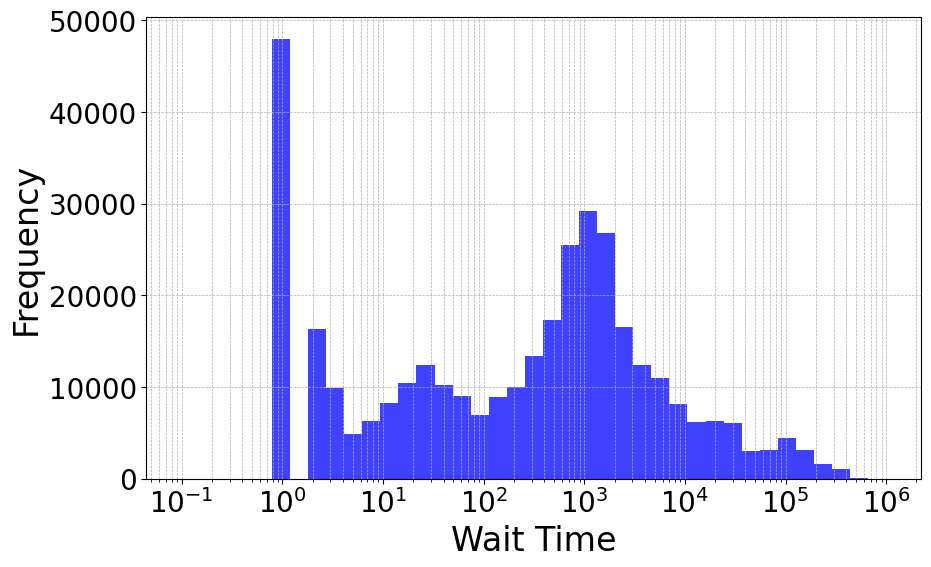

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter out non-positive values (log scale can't handle zero or negative)
wait_times = Y['Wait Time']
wait_times = wait_times[wait_times > 0]

# Define log-spaced bins
log_bins = np.logspace(-1, 6, num=40)  # from 0.1 to 1,000,000 with 50 bins

plt.figure(figsize=(10, 6))
sns.histplot(wait_times, bins=log_bins, kde=False, color='blue')

# Set x-axis to log scale and use matching ticks
plt.xscale('log')
plt.xticks([0.1, 1, 10, 100, 1000, 10000, 100000, 1000000], fontsize=12)

# Customize labels
plt.xlabel('Wait Time', fontsize=24)
plt.ylabel('Frequency', fontsize=24)
plt.tick_params(axis='both', labelsize=20)  # Set font size for both x and y ticks
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show plot
plt.show()


/cluster/tufts/patralab/bgaikw01/condaenv/imixray/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


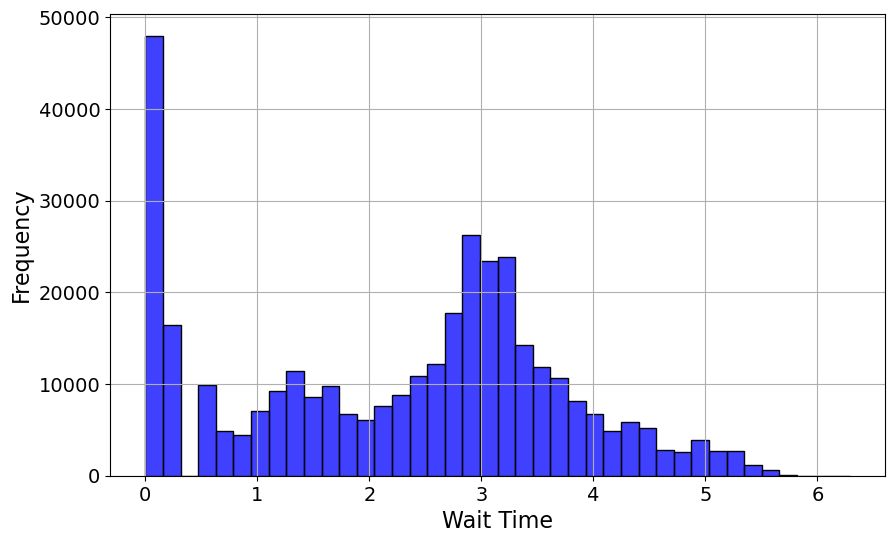

X.shape (396879, 12)
X_train.shape (317503, 12)
Resource
expanse.sdsc.xsede.org         183417
delta-gpu.ncsa.xsede.org        39438
bridges2-gpu.psc.xsede.org      26732
bridges2-rm.psc.xsede.org       26494
stampede2.tacc.xsede            13954
anvil.purdue.xsede.org          11232
delta-cpu.ncsa.xsede.org        10883
expanse-gpu.sdsc.xsede.org       5044
anvil-gpu.purdue.xsede.org        266
ookami.stonybrook.xsede.org        29
bridges2-em.psc.xsede.org          14
Name: count, dtype: int64
[0.]


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(np.log10(Y['Wait Time']), bins=40, kde=False, color='blue')

# Customize plot
plt.xlabel('Wait Time', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.tick_params(axis='both', labelsize=14)  # Set font size for both x and y ticks
# plt.title('Distribution of Trainset Wait Time', fontsize=16)
plt.grid(True)

# Show plot
plt.show()

print("X.shape",X.shape)
print("X_train.shape",X_train.shape)
print(X_train['Resource'].value_counts())
print(X_train['Requested Nodes'].unique())


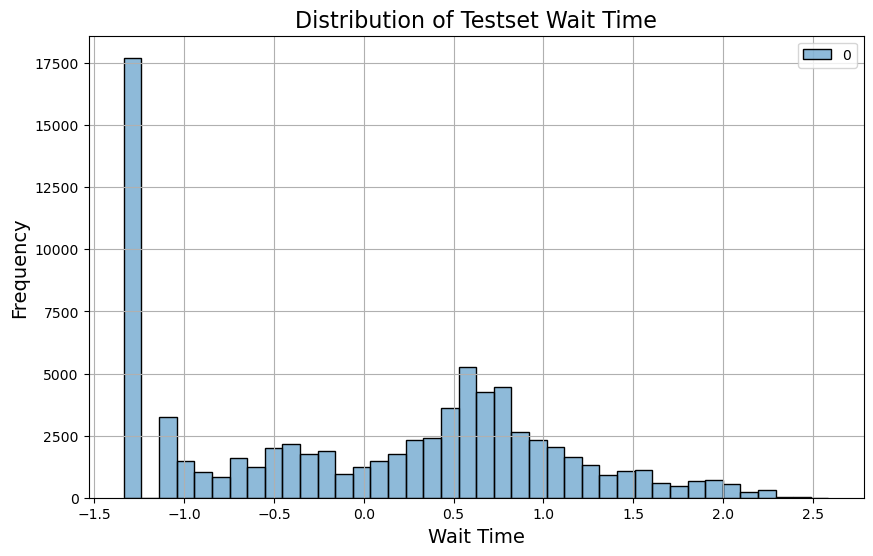

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(y_test_tensor, bins=40, kde=False, color='blue')

# Customize plot
plt.xlabel('Wait Time', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Testset Wait Time', fontsize=16)
plt.grid(True)

# Show plot
plt.show()

In [12]:
import numpy as np
import torch
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
# from skgarden import RandomForestQuantileRegressor

# Convert PyTorch Tensors to NumPy arrays for RandomForest
X_train_np = X_train_tensor.cpu().numpy()
Y_train_np = y_train_tensor.cpu().numpy().ravel()
X_test_np = X_test_tensor.cpu().numpy()
Y_test_np = y_test_tensor.cpu().numpy().ravel()

# Define Random Forest model
rf_model = RandomForestRegressor(n_estimators=500,  # Number of trees
                                 max_depth=50,      # Maximum depth of trees
#                                  bootstrap=False,   # True
                                 random_state=42,   # Random seed for reproducibility
                                 n_jobs=-1)         # Use all CPU cores

# Train the model
rf_model.fit(X_train_np, Y_train_np, sample_weight=sample_weights)
# rf_model.fit(X_train_np, Y_train_np)

# qrf = RandomForestQuantileRegressor(n_estimators=100, random_state=42)
# qrf.fit(X_train, Y_train)

# Make predictions on test data
predictions = rf_model.predict(X_test_np)

# Convert back to original scale (inverse log10 transformation)
# Y_test_orig = scaler_y.inverse_transform(Y_test_np.reshape(-1, 1))
# predictions_orig = scaler_y.inverse_transform(predictions.reshape(-1, 1))
Y_test_orig = np.power(10, scaler_y.inverse_transform(Y_test_np.reshape(-1, 1)))
# Y_test_orig = np.power(10, Y_test_orig)
predictions_orig = np.power(10, scaler_y.inverse_transform(predictions.reshape(-1, 1)))
# predictions_orig = np.power(10, predictions_orig)
print("max(Y_test_orig)",max(Y_test_orig))

# Compute MAE (Mean Absolute Error)
mae = mean_absolute_error(Y_test_orig, predictions_orig)

# Calculate accuracy within 5% error
correct_5_percent = np.sum(np.abs((predictions_orig - Y_test_orig) / Y_test_orig) < 0.05)
accuracy_5_percent = correct_5_percent / len(Y_test_np)

correct_10_percent = np.sum(np.abs((predictions_orig - Y_test_orig) / Y_test_orig) < 0.10)
accuracy_10_percent = correct_10_percent / len(Y_test_np)

correct_5_minutes = np.sum(np.abs(predictions_orig - Y_test_orig) < 300)
accuracy_5_minutes = correct_5_minutes / len(Y_test_np)

correct_10_minutes = np.sum(np.abs(predictions_orig - Y_test_orig) < 600)
accuracy_10_minutes = correct_10_minutes / len(Y_test_np)



max(Y_test_orig) [1037067.8]


In [13]:
# CALCULATE RESULTS FOR THE ENTIRE DATASET
# Print results
print(f"MAE: {mae:.4f}")
print(f"Accuracy (5% error threshold): {accuracy_5_percent:.3f}")
print(f"Accuracy (10% error threshold): {accuracy_10_percent:.3f}")
print(f"Accuracy for error less than 5 minutes: {accuracy_5_minutes:.3f}")
print(f"Accuracy for error less than 10 minutes: {accuracy_10_minutes:.3f}")

# Print sample predictions
preds = np.concatenate((Y_test_orig.astype(int), predictions_orig.astype(int)), axis=1)
print(preds)

MAE: 787.5282
Accuracy (5% error threshold): 0.701
Accuracy (10% error threshold): 0.745
Accuracy for error less than 5 minutes: 0.928
Accuracy for error less than 10 minutes: 0.941
[[2388 2388]
 [3142 3141]
 [  39   39]
 ...
 [ 603  602]
 [ 662  662]
 [   0    0]]


Error less than 1 hour 78707
Error more than 1 hour 669
Ground truth wait times more than 1 day: 2020
Ground truth wait times more than 30 minutes: 18188
Ground truth wait times more than 1 hour: 12399
Ground truth wait times more than 12 hours: 3083


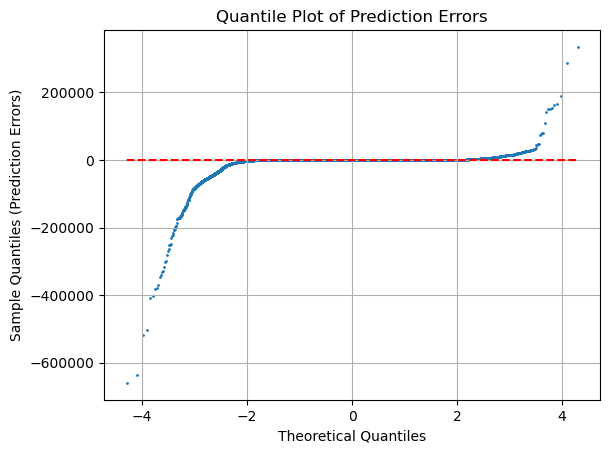

In [14]:
# DISPLAY RESULTS FOR THE LARGER WAIT TIMES

import scipy.stats as stats

errors = predictions_orig[:,0] - Y_test_orig[:,0]

print("Error less than 1 hour", sum((errors < 3600)))
print("Error more than 1 hour", sum((errors > 3600)))
print("Ground truth wait times more than 1 day:", sum((Y_test_orig[:,0] > 86400)))
print("Ground truth wait times more than 30 minutes:", sum((Y_test_orig[:,0] > 1800)))
print("Ground truth wait times more than 1 hour:", sum((Y_test_orig[:,0] > 3600)))
print("Ground truth wait times more than 12 hours:", sum((Y_test_orig[:,0] > 43200)))


# Quantile plot (QQ-plot) of prediction errors
theoretical_q, sample_q = stats.probplot(errors, dist="norm", fit=False)

plt.scatter(theoretical_q, sample_q, s=1, alpha=1)  # s controls dot size
plt.plot(theoretical_q, theoretical_q, color='red', linestyle='--')  # 45° reference line

plt.title("Quantile Plot of Prediction Errors")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles (Prediction Errors)")
plt.grid(True)
plt.show()

In [19]:
# Compute the error for ground truth wait times more than 30 minutes

mask = Y_test_orig[:, 0] > 1800  # assuming Y_test_orig is in minutes

# Apply the mask to both predictions and ground truth
filtered_predictions = predictions_orig[mask, 0]
filtered_ground_truth = Y_test_orig[mask, 0]

# Compute errors on the filtered set
errors = filtered_predictions - filtered_ground_truth

# Compute MAE (Mean Absolute Error)
mae = mean_absolute_error(filtered_ground_truth, filtered_predictions)

# Calculate accuracy within 5% error
correct_5_percent = np.sum(np.abs((filtered_predictions - filtered_ground_truth) / filtered_ground_truth) < 0.05)
accuracy_5_percent = correct_5_percent / len(filtered_ground_truth)

correct_10_percent = np.sum(np.abs((filtered_predictions - filtered_ground_truth) / filtered_ground_truth) < 0.10)
accuracy_10_percent = correct_10_percent / len(filtered_ground_truth)

correct_5_minutes = np.sum(np.abs(filtered_predictions - filtered_ground_truth) < 300)
accuracy_5_minutes = correct_5_minutes / len(filtered_ground_truth)

correct_10_minutes = np.sum(np.abs(filtered_predictions - filtered_ground_truth) < 600)
accuracy_10_minutes = correct_10_minutes / len(filtered_ground_truth)

print(f"MAE: {mae:.4f}")
print(f"Accuracy (5% error threshold): {accuracy_5_percent:.3f}")
print(f"Accuracy (10% error threshold): {accuracy_10_percent:.3f}")

print(f'accuracy_5_minutes: {accuracy_5_minutes:.3f}')
print(f'accuracy_10_minutes: {accuracy_10_minutes:.3f}')

MAE: 3228.3869
Accuracy (5% error threshold): 0.801
Accuracy (10% error threshold): 0.847
accuracy_5_minutes: 0.738
accuracy_10_minutes: 0.779


/tmp/ipykernel_17927/4279992460.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


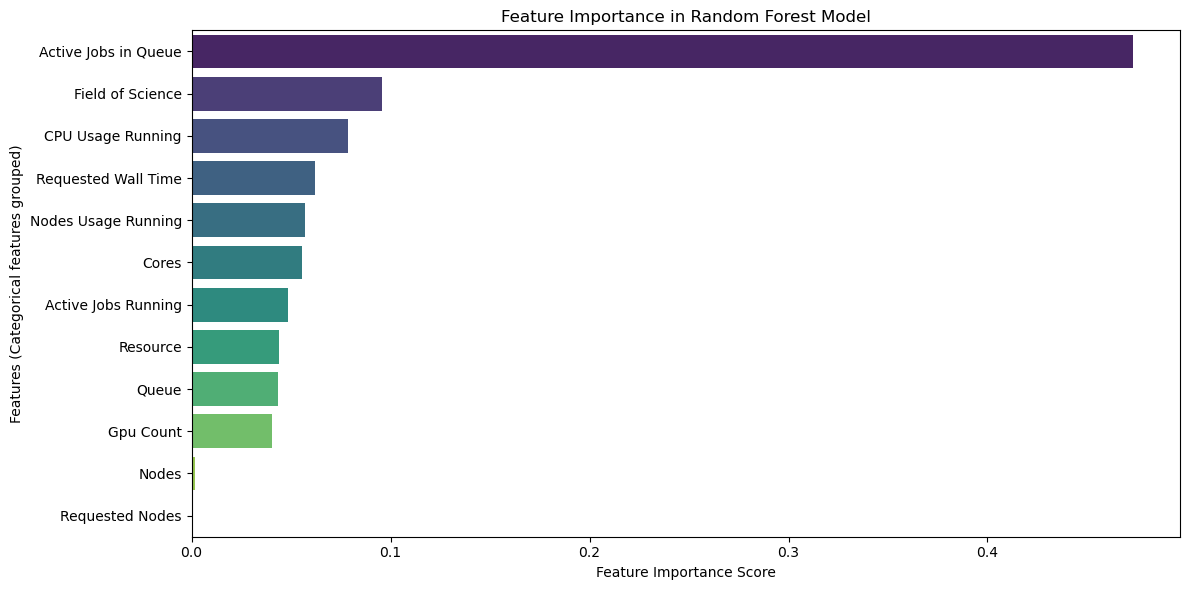

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import defaultdict

# Get feature importances from your trained RandomForest model
feature_importances = rf_model.feature_importances_

# Extract feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Dictionary to accumulate importance scores
grouped_importances = defaultdict(float)

# Loop through each feature name and its importance
for feature_name, importance in zip(feature_names, feature_importances):
    # If it's one-hot encoded, split at '__' to get the original feature
    if '_' in feature_name:
        base_feature = feature_name.split('_')[2]  # e.g., 'Queue__A' -> 'Queue'
    else:
        base_feature = feature_name
    
    # Accumulate the importance
    grouped_importances[base_feature] += importance

# Convert the grouped importances into a DataFrame
importance_df = pd.DataFrame({
    'Feature': list(grouped_importances.keys()),
    'Importance': list(grouped_importances.values())
})

# Sort by importance and take the top 15
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(15)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features (Categorical features grouped)')
plt.title('Feature Importance in Random Forest Model')
plt.tight_layout()
plt.show()


# MLP Model

In [22]:
class RegressionNN(nn.Module):
    def __init__(self,dropout_prob=0.2):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(68, 256)  # Input layer
        self.fc2 = nn.Linear(256, 1024)  # Hidden layer
        self.fc3 = nn.Linear(1024, 1024)  # Output layer (8 classes)
        self.fc4 = nn.Linear(1024, 1024)  # Output layer (8 classes)
        self.fc5 = nn.Linear(1024, 1024)  # Output layer (8 classes)
        self.fc6 = nn.Linear(1024, 1024)  # Output layer (8 classes)
        self.fc7 = nn.Linear(1024, 1024)  # Output layer (8 classes)
        self.fc8 = nn.Linear(1024, 1024)  # Output layer (8 classes)
        self.fc9 = nn.Linear(1024, 256)  # Output layer (8 classes)
        self.fc10 = nn.Linear(256, 1)  # Output layer (8 classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
#         x = self.dropout(x) 
        x = self.relu(self.fc2(x))
#         x = self.dropout(x) 
        x = self.relu(self.fc3(x))
#         x = self.dropout(x) 
        x = self.relu(self.fc4(x))
#         x = self.dropout(x) 
        x = self.relu(self.fc5(x))
#         x = self.dropout(x) 
        x = self.relu(self.fc6(x))
#         x = self.dropout(x) 
        x = self.relu(self.fc7(x))
#         x = self.dropout(x) 
        x = self.relu(self.fc8(x))
#         x = self.dropout(x) 
        x = self.relu(self.fc9(x))
        x = self.fc10(x)
        return x  # Logits for CrossEntropyLoss

model = RegressionNN()
model.cuda()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',           # Reduce when the monitored metric is minimized (e.g., validation loss)
    factor=0.5,           # Factor by which the learning rate will be reduced
    patience=25,          # Number of epochs with no improvement before reducing the learning rate
    min_lr=3e-5,
    verbose=True          # Print messages when the learning rate is reduced
)
n_epochs = 2000
best_test_acc_5 = 0
best_test_acc_10 = 0
best_accuracy_5_minutes = 0
best_accuracy_10_minutes = 0

# print("X_train_tensor.shape",X_train_tensor.shape)
# print("X_train_tensor[:4]",X_train_tensor[:4])
        
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for inputs, gt, weights in train_loader:
#     for inputs, gt in train_loader:
#         print("inputs.shape",inputs.shape)
        inputs = inputs.cuda()
        gt = gt.cuda()
        weights = weights.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, gt)
        weighted_loss = (loss * weights).mean()

#         loss.backward()
        weighted_loss.backward()
        optimizer.step()
        running_loss += loss.item()

#     print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.7f}")

    # Validation
    model.eval()
    correct_5 = 0
    correct_10 = 0
    correct_5_minutes = 0
    correct_10_minutes = 0
    total = 0
    mae_sum = 0 

    with torch.no_grad():
        for inputs, gt in test_loader:
            inputs = inputs.cuda()
            gt = gt.cuda()
            outputs = model(inputs)
            # _, predicted = torch.max(outputs, 1)
            total += gt.cpu().size(0)
            # print("abs(predicted - labels)",abs(outputs - gt))
            
            gt_u = scaler_y.inverse_transform(gt.cpu())
            gt = torch.pow(10, torch.tensor(gt_u))
            outputs_u = scaler_y.inverse_transform(outputs.cpu())
            outputs = torch.pow(10, torch.tensor(outputs_u))
            
            correct_5 += ((abs((outputs - gt) / gt)) < 0.05).sum().cpu().item()
            correct_10 += ((abs((outputs - gt) / gt)) < 0.10).sum().cpu().item()
            mae_sum += (abs(outputs - gt)).sum()
            correct_5_minutes += (abs(outputs - gt) < 300).sum().cpu().item()
            correct_10_minutes += (abs(outputs - gt) < 600).sum().cpu().item()
            
    scheduler.step(running_loss)
    
    test_acc_5 = correct_5 / total
    test_acc_10 = correct_10 / total
    mae = (mae_sum / total)
    accuracy_5_minutes = correct_5_minutes / total
    accuracy_10_minutes = correct_10_minutes / total

    print(f"Epoch {epoch+1}", f"Test Accuracy: {test_acc_5}")
    
    if test_acc_5 > best_test_acc_5:
        best_test_acc_5 = test_acc_5
        best_test_acc_10 = test_acc_10
        best_model = model
        best_mae = mae
        best_accuracy_5_minutes = accuracy_5_minutes
        best_accuracy_10_minutes = accuracy_10_minutes
        print("best_test_acc @ 5", f"{best_test_acc_5:.4f}")
        print("best_test_acc @ 10", f"{best_test_acc_10:.4f}")
        print("best_test_mae", f"{best_mae:.4f}")
        print("best accuracy_5_minutes", f"{accuracy_5_minutes:.4f}")
        print("best accuracy_10_minutes", f"{accuracy_10_minutes:.4f}")
        print("-------------------------------")

print("best_test_acc 5% err", f"{best_test_acc_5:.4f}")
print("best_test_acc 10% err", f"{best_test_acc_10:.4f}")
print("best_test_mae", f"{best_mae:.4f}")
print("best accuracy_5_minutes", f"{best_accuracy_5_minutes:.4f}")
print("best accuracy_10_minutes", f"{best_accuracy_10_minutes:.4f}")
# print(np.concatenate((gt.astype(int), outputs.astype(int)), axis=1))
print(np.concatenate((gt.cpu().numpy().astype(int), outputs.cpu().numpy().astype(int)), axis=1))

torch.save(best_model, 'best_model_12_23_log.pth')

Epoch 1 Test Accuracy: 0.04366559161459383
best_test_acc @ 5 0.0437
best_test_acc @ 10 0.0985
best_test_mae 9479.1481
best accuracy_5_minutes 0.6708
best accuracy_10_minutes 0.7718
-------------------------------
Epoch 2 Test Accuracy: 0.040818383390445474
Epoch 3 Test Accuracy: 0.03920580528119331
Epoch 4 Test Accuracy: 0.12560471679096957
best_test_acc @ 5 0.1256
best_test_acc @ 10 0.2113
best_test_mae 3208.0405
best accuracy_5_minutes 0.7321
best accuracy_10_minutes 0.8030
-------------------------------
Epoch 5 Test Accuracy: 0.07957065107841162
Epoch 6 Test Accuracy: 0.044106530941342474
Epoch 7 Test Accuracy: 0.05565914130215682
Epoch 8 Test Accuracy: 0.08481152993348115
Epoch 9 Test Accuracy: 0.11002066115702479
Epoch 10 Test Accuracy: 0.062285829469864946
Epoch 11 Test Accuracy: 0.026519350937311024
Epoch 12 Test Accuracy: 0.1406722434992945
best_test_acc @ 5 0.1407
best_test_acc @ 10 0.2522
best_test_mae 2318.8029
best accuracy_5_minutes 0.7706
best accuracy_10_minutes 0.8168


In [43]:
correct_5 = 0
correct_10 = 0
correct_5_minutes = 0
correct_10_minutes = 0
total = 0
mae_sum = 0 

all_gts = []
all_preds = []
all_filtered_gts = []
all_filtered_preds = []
with torch.no_grad():
    for inputs, gt in test_loader:
        inputs = inputs.cuda()
        gt = gt.cuda()
        outputs = best_model(inputs)
        # _, predicted = torch.max(outputs, 1)
        total += gt.cpu().size(0)
        # print("abs(predicted - labels)",abs(outputs - gt))

        gt_u = scaler_y.inverse_transform(gt.cpu())
        gt = torch.pow(10, torch.tensor(gt_u))
        outputs_u = scaler_y.inverse_transform(outputs.cpu())
        outputs = torch.pow(10, torch.tensor(outputs_u))
        
        mask = gt[:, 0] > 1800  # mask for ground truth > 30 minutes

        # Filter predictions and ground truths
        filtered_preds = outputs[mask, 0]
        filtered_gts = gt[mask, 0]

        # Store for final error computation
        all_filtered_preds.append(filtered_preds)
        all_filtered_gts.append(filtered_gts)
        
        all_preds.append(outputs)
        all_gts.append(gt)

all_filtered_predictions = torch.cat(all_filtered_preds)
all_filtered_ground_truths = torch.cat(all_filtered_gts)

all_predictions = torch.cat(all_preds)
all_ground_truths = torch.cat(all_gts)

correct_5 = ((abs((all_filtered_predictions - all_filtered_ground_truths) / all_filtered_ground_truths)) < 0.05).sum().cpu().item()
correct_10 = ((abs((all_filtered_predictions - all_filtered_ground_truths) / all_filtered_ground_truths)) < 0.10).sum().cpu().item()
mae_sum = (abs(all_filtered_predictions - all_filtered_ground_truths)).sum()
correct_5_minutes = (abs(all_filtered_predictions - all_filtered_ground_truths) < 300).sum().cpu().item()
correct_10_minutes = (abs(all_filtered_predictions - all_filtered_ground_truths) < 600).sum().cpu().item()

test_acc_5 = correct_5 / all_filtered_ground_truths.shape[0]
test_acc_10 = correct_10 / all_filtered_ground_truths.shape[0]
mae = (mae_sum / all_filtered_ground_truths.shape[0])
accuracy_5_minutes = correct_5_minutes / all_filtered_ground_truths.shape[0]
accuracy_10_minutes = correct_10_minutes / all_filtered_ground_truths.shape[0]

# print(np.concatenate((np.array(all_filtered_ground_truths).astype(int), np.array(all_filtered_predictions).astype(int)), axis=1))

print("test_acc @ 5", f"{test_acc_5:.4f}")
print("best_test_acc @ 10", f"{test_acc_10:.4f}")
print("best_test_mae", f"{mae:.4f}")
print("best accuracy_5_minutes", f"{accuracy_5_minutes:.4f}")
print("best accuracy_10_minutes", f"{accuracy_10_minutes:.4f}")


# DISPLAY RESULTS FOR THE LARGER WAIT TIMES

import scipy.stats as stats

errors = all_predictions[:,0] - all_ground_truths[:,0]


print("\nError less than 1 hour", sum((errors < 3600)))
print("Error more than 1 hour", sum((errors > 3600)))
print("Ground truth wait times more than 30 minutes:", sum((all_ground_truths[:,0] > 1800)))
print("Ground truth wait times more than 1 hour:", sum((all_ground_truths[:,0] > 3600)))
print("Ground truth wait times more than 12 hours:", sum((all_ground_truths[:,0] > 43200)))
print("Ground truth wait times more than 1 day:", sum((all_ground_truths[:,0] > 86400)))



test_acc @ 5 0.7952
best_test_acc @ 10 0.8556
best_test_mae 3240.9457
best accuracy_5_minutes 0.6728
best accuracy_10_minutes 0.7360

Error less than 1 hour tensor(78483)
Error more than 1 hour tensor(893)
Ground truth wait times more than 30 minutes: tensor(18188)
Ground truth wait times more than 1 hour: tensor(12399)
Ground truth wait times more than 12 hours: tensor(3083)
Ground truth wait times more than 1 day: tensor(2020)
